<a href="https://colab.research.google.com/github/brodyu/ml-streamflow-forecasting/blob/main/colab_xgboost_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

# check xgboost version
!pip uninstall xgboost
!pip install -U xgboost
import xgboost as xg
print(xg.__version__)

from scipy import stats
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, Normalizer

Found existing installation: xgboost 1.5.1
Uninstalling xgboost-1.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-1.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost.libs/libgomp-a34b3233.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/xgboost/*
Proceed (y/n)? y
  Successfully uninstalled xgboost-1.5.1
  Using cached xgboost-1.5.1-py3-none-manylinux2014_x86_64.whl (173.5 MB)
1.5.1


In [2]:
# raw url link from GitHub repo: https://github.com/brodyu/streamflow-forecasting-deep-learning/blob/main/data/Manoa_reduced.csv

url = "https://raw.githubusercontent.com/brodyu/streamflow-forecasting-deep-learning/main/data/Manoa_reduced.csv"
df = pd.read_csv(url)
df.head()

,Date,Discharge,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
0,10/1/11,2.64,34,23,10.2,6,22,31,31,28,9,51,74,1.5,1009,34,9,304,6
1,10/2/11,2.63,32,23,8.8,6,23,30,30,27,5,60,84,4.8,1010,32,5,258,3
2,10/3/11,2.74,34,23,10.2,6,22,30,30,27,7,51,78,11.6,1010,34,7,160,4
3,10/4/11,5.92,37,21,11.6,8,19,30,30,28,6,22,63,0.0,1008,37,8,165,4
4,10/5/11,2.92,35,22,11.6,8,18,31,31,29,6,22,56,0.1,1009,35,10,105,4


In [3]:
df = df.set_index("Date")
df.head()

,Discharge,maxtempC,mintempC,sunHour,uvIndex,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
Date,,,,,,,,,,,,,,,,,,
10/1/11,2.64,34,23,10.2,6,22,31,31,28,9,51,74,1.5,1009,34,9,304,6
10/2/11,2.63,32,23,8.8,6,23,30,30,27,5,60,84,4.8,1010,32,5,258,3
10/3/11,2.74,34,23,10.2,6,22,30,30,27,7,51,78,11.6,1010,34,7,160,4
10/4/11,5.92,37,21,11.6,8,19,30,30,28,6,22,63,0.0,1008,37,8,165,4
10/5/11,2.92,35,22,11.6,8,18,31,31,29,6,22,56,0.1,1009,35,10,105,4


In [4]:
# Feature Engineering
df['Discharge'] = df["Discharge"].rolling(window=3).mean()
df = df.iloc[2:]
print(df)

         Discharge  maxtempC  ...  winddirDegree  windspeedKmph
Date                          ...                              
10/3/11   2.670000        34  ...            160              4
10/4/11   3.763333        37  ...            165              4
10/5/11   3.860000        35  ...            105              4
10/6/11   3.950000        34  ...            161              4
10/7/11   3.270000        31  ...            248              4
...            ...       ...  ...            ...            ...
3/27/20  31.820000        28  ...            134              4
3/28/20  41.320000        34  ...            178              3
3/29/20  50.833333        29  ...            142              2
3/30/20  35.000000        29  ...            121              4
3/31/20  24.066667        32  ...            189              3

[3103 rows x 18 columns]


In [5]:
def outliers(df, int):
  z_scores = stats.zscore(df)
  abs_z_scores = np.abs(z_scores)
  filtered_entries = (abs_z_scores < int).all(axis=1)
  df = df[filtered_entries]
  return df

In [6]:
def normalization(df):
  values = df.values
  # convert to floats
  values = values.astype('float64')
  # Normalization
  min_max_scaler = MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(values)
  values = pd.DataFrame(x_scaled)
  print(values)
  return values

In [7]:
df = outliers(df, 3)
df = normalization(df)

            0     1         2         3   ...    14        15        16        17
0     0.030358  0.60  0.666667  0.623188  ...  0.60  0.428571  0.436578  0.428571
1     0.047321  0.75  0.444444  0.826087  ...  0.75  0.500000  0.451327  0.428571
2     0.048821  0.65  0.555556  0.826087  ...  0.65  0.642857  0.274336  0.428571
3     0.050217  0.60  0.555556  0.826087  ...  0.60  0.571429  0.439528  0.428571
4     0.039667  0.45  0.666667  0.623188  ...  0.45  0.571429  0.696165  0.428571
...        ...   ...       ...       ...  ...   ...       ...       ...       ...
2800  0.170821  0.45  0.777778  0.014493  ...  0.45  0.642857  0.404130  0.714286
2801  0.482623  0.30  0.666667  0.420290  ...  0.30  0.500000  0.359882  0.428571
2802  0.630017  0.60  0.666667  0.826087  ...  0.60  0.642857  0.489676  0.285714
2803  0.777617  0.35  0.666667  0.217391  ...  0.35  0.357143  0.383481  0.142857
2804  0.362329  0.50  0.666667  0.217391  ...  0.50  0.500000  0.522124  0.285714

[2805 rows x 18

In [8]:
# split data into input and output columns
data = df.values
print(data)
X, y = data[:, 1: ], data[:, 0]

[[0.03035788 0.6        0.66666667 ... 0.42857143 0.43657817 0.42857143]
 [0.04732106 0.75       0.44444444 ... 0.5        0.45132743 0.42857143]
 [0.04882085 0.65       0.55555556 ... 0.64285714 0.27433628 0.42857143]
 ...
 [0.63001655 0.6        0.66666667 ... 0.64285714 0.48967552 0.28571429]
 [0.77761688 0.35       0.66666667 ... 0.35714286 0.38348083 0.14285714]
 [0.36232933 0.5        0.66666667 ... 0.5        0.52212389 0.28571429]]


In [9]:
print(X)

[[0.6        0.66666667 0.62318841 ... 0.42857143 0.43657817 0.42857143]
 [0.75       0.44444444 0.82608696 ... 0.5        0.45132743 0.42857143]
 [0.65       0.55555556 0.82608696 ... 0.64285714 0.27433628 0.42857143]
 ...
 [0.6        0.66666667 0.82608696 ... 0.64285714 0.48967552 0.28571429]
 [0.35       0.66666667 0.2173913  ... 0.35714286 0.38348083 0.14285714]
 [0.5        0.66666667 0.2173913  ... 0.5        0.52212389 0.28571429]]


In [10]:
print(y)

[0.03035788 0.04732106 0.04882085 ... 0.63001655 0.77761688 0.36232933]


In [11]:
xtrain, xtest, ytrain, ytest=train_test_split(X, y, test_size=0.15)

In [12]:
xgbr = xg.XGBRegressor(verbosity=0) 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)


In [13]:
xgbr.fit(xtrain, ytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=0)

In [14]:
score = xgbr.score(xtrain, ytrain)  
print("Training score: ", score)

Training score:  0.9095609860559484


In [15]:
scores = cross_val_score(xgbr, xtrain, ytrain,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: -0.22


In [16]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: -0.20


In [17]:
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)

MSE: 0.03


In [18]:
print("RMSE: %.2f" % (mse**(1/2.0)))

RMSE: 0.17


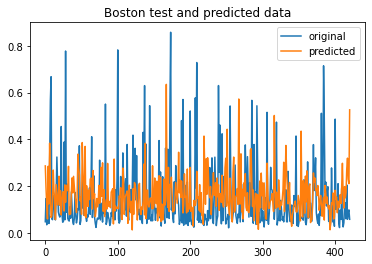

In [19]:
x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="original")
plt.plot(x_ax, ypred, label="predicted")
plt.title("Manoa stream test and predicted data")
plt.legend()
plt.show()